In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import urllib
import os
import sys
import random
import glob
import re
import time
from io import StringIO
import bs4

%load_ext autoreload
%autoreload 2

sys.path.append("../")
from cleaner import *

In [2]:
docs = glob.glob("../data/raw/*.pdf")

In [3]:
t = docs[0]
t

'../data/raw/transparency_ministerial_January-March_2015.pdf'

In [4]:
"""
See:
- https://euske.github.io/pdfminer/programming.html
- http://denis.papathanasiou.org/posts/2010.08.04.post.html
"""

import pdfminer

from pdfminer.pdfparser import PDFParser
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfpage import PDFTextExtractionNotAllowed
from pdfminer.pdfinterp import PDFResourceManager
from pdfminer.pdfinterp import PDFPageInterpreter
from pdfminer.pdfdevice import PDFDevice

from pdfminer.layout import LAParams
from pdfminer.converter import PDFPageAggregator

laparams = LAParams()

fp = open(t, 'rb')
parser = PDFParser(fp)
document = PDFDocument(parser)

if not document.is_extractable:
    raise PDFTextExtractionNotAllowed

rsrcmgr = PDFResourceManager()
device = PDFPageAggregator(rsrcmgr, laparams=laparams)
interpreter = PDFPageInterpreter(rsrcmgr, device)

layouts = []
for page in PDFPage.create_pages(document):
    interpreter.process_page(page)
    layouts.append(device.get_result())

In [56]:
l = layouts[0]

texts = []
rects = []
other = []

for n, e in enumerate(l):
    if isinstance(e, pdfminer.layout.LTTextBoxHorizontal):
        texts.append(e)
    elif isinstance(e, pdfminer.layout.LTRect):
        rects.append(e)
    else:
        other.append(e)
        
print("rects: {}".format(len(rects)))
print("texts: {}".format(len(texts)))
print("other: {}".format(len(other)))

rects: 370
texts: 27
other: 0


In [57]:
r = rects[0]

In [58]:
def get_bounds(rects):
    xmin = min(r.bbox[0] for r in rects)
    xmax = max(r.bbox[2] for r in rects)
    ymin = min(r.bbox[1] for r in rects)
    ymax = max(r.bbox[3] for r in rects)
    return (xmin, ymin, xmax,ymax)

get_bounds(rects)

(66.384, 308.69, 511.80001, 779.88)

In [59]:
def draw_rect(rect, ax, color="black"):
    draw_rect_bbox(rect.bbox, ax, color)
    
def draw_rect_bbox((x0,y0,x1,y1), ax, color):
    ax.add_patch( 
        patches.Rectangle(
            (x0, y0),
            x1 - x0,
            y1 - y0,
            fill=False,
            color=color
        )    
    )
    
TEXT_ELEMENTS = [
    pdfminer.layout.LTTextBox,
    pdfminer.layout.LTTextBoxHorizontal,
    pdfminer.layout.LTTextLine,
    pdfminer.layout.LTTextLineHorizontal
]
    
def flatten(lst):
    return [subelem for elem in lst for subelem in elem]

def extract_characters(element):
    if isinstance(element, pdfminer.layout.LTChar):
        return [element]
    
    if any(isinstance(element, i) for i in TEXT_ELEMENTS):
        elements = []
        for e in element:
            elements += extract_characters(e)
        return elements
    
    if isinstance(element, list):
        return flatten([extract_characters(l) for l in element])
    
    return []

characters = extract_characters(texts)

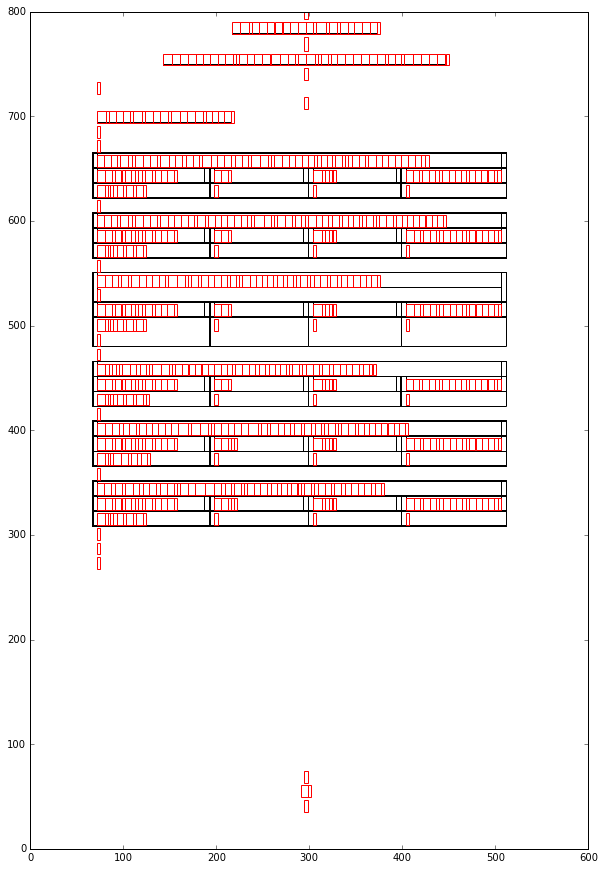

In [60]:
from matplotlib import patches

fig, ax = plt.subplots(figsize = (10,15))

for rect in rects:
    draw_rect(rect, ax)
    
for c in characters:
    draw_rect(c, ax, "red")

plt.xlim(0,600)
plt.ylim(0,800)
plt.show()

In [61]:
record = {k:[] for k in characters}

def check_for_overlap(char, rect):
    x0,y0,x1,y1 = char.bbox
    rx0, ry0, rx1, ry1 = rect.bbox
    return (x1 >= rx0 and 
            x1 <= rx1 and
            y1 >= ry0 and
            y1 <= ry1)

for char in characters:
    for rect in rects:
        if check_for_overlap(char, rect):
            record[char].append(rect)

In [62]:
len([len(v) for v in record.values() if len(v) > 0])

589

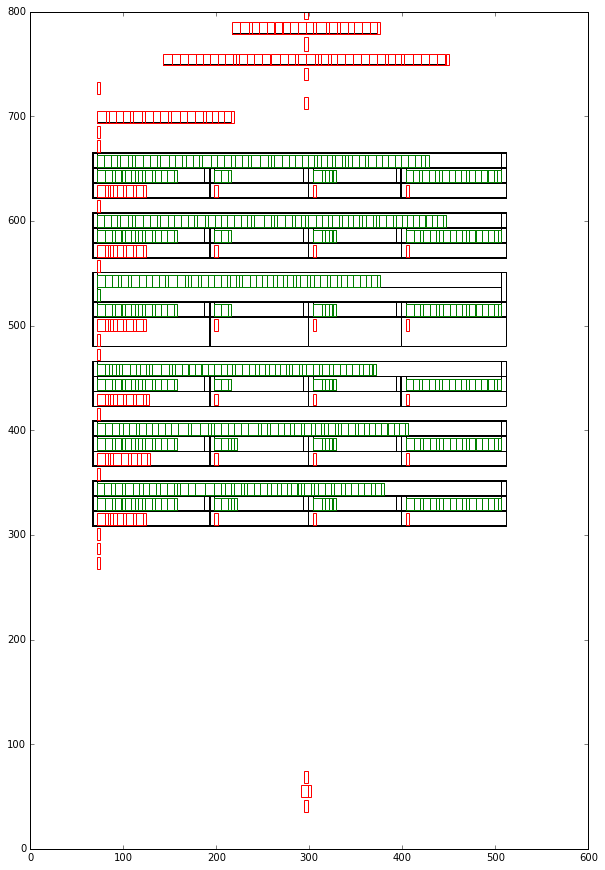

In [63]:
from matplotlib import patches

fig, ax = plt.subplots(figsize = (10,15))

for rect in rects:
    draw_rect(rect, ax)
    
for c in characters:
    draw_rect(c, ax, "red")
    
for c,v in record.items():
    if len(v) > 0:
        draw_rect(c, ax, "green")

plt.xlim(0,600)
plt.ylim(0,800)
plt.show()

(array([ 339.,    0.,   24.,    0.,    0.,    0.,    0.,    0.,    0.,    7.]),
 array([  2.30390400e-01,   6.00362487e+02,   1.20049458e+03,
          1.80062668e+03,   2.40075878e+03,   3.00089088e+03,
          3.60102297e+03,   4.20115507e+03,   4.80128717e+03,
          5.40141926e+03,   6.00155136e+03]),
 <a list of 10 Patch objects>)

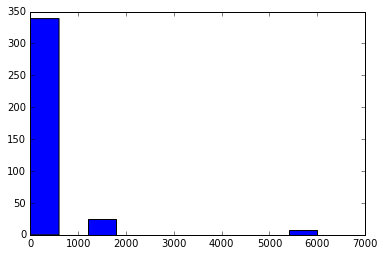

In [64]:
def width(rect):
    x0,y0,x1,y1 = rect.bbox
    return min(x1-x0, y1-y0)

def length(rect):
    x0,y0,x1,y1 = rect.bbox
    return max(x1-x0, y1-y0)

def area(rect):
    x0,y0,x1,y1 = rect.bbox
    return (x1-x0) * (y1-y0)

plt.hist([area(r) for r in rects], bins=10)

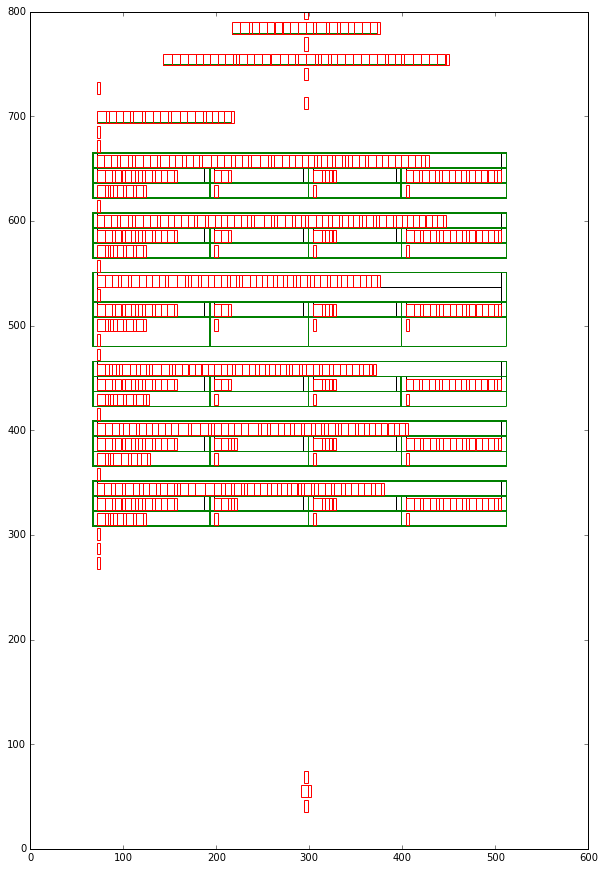

In [65]:
from matplotlib import patches

fig, ax = plt.subplots(figsize = (10,15))

for rect in rects:
    c = "green" if width(rect) < 2 else "black"
    draw_rect(rect, ax, c)
    
for c in characters:
    draw_rect(c, ax, "red")

plt.xlim(0,600)
plt.ylim(0,800)
plt.show()

In [66]:
def cast_as_line(rect):
    x0,y0,x1,y1 = rect.bbox
    
    if x1-x0 > y1-y0:
        return (x0, y0, x1, y0, "H")
    else:
        return (x0, y0, x0, y1, "V")

In [67]:
lines = [cast_as_line(r) for r in rects 
         if width(r) < 2
         and area(r) > 1]

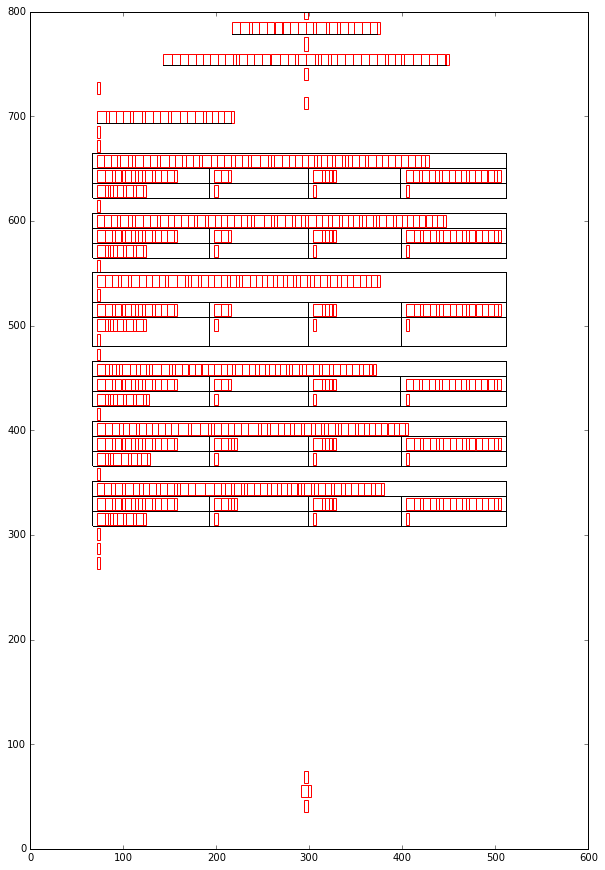

In [68]:
from matplotlib import patches

fig, ax = plt.subplots(figsize = (10,15))

for l in lines:
    x0,y0,x1,y1,_ = l
    plt.plot([x0, x1], [y0, y1], 'k-')
    
for c in characters:
    draw_rect(c, ax, "red")

plt.xlim(0,600)
plt.ylim(0,800)
plt.show()

In [69]:
def does_it_intersect(x, (xmin, xmax)):
    return (x <= xmax and x >= xmin)

def find_bounding_rectangle((x,y), lines):
    
    v_intersects = [l for l in lines
                    if l[4] == "V"
                    and does_it_intersect(y, (l[1], l[3]))]
    
    h_intersects = [l for l in lines
                    if l[4] == "H"
                    and does_it_intersect(x, (l[0], l[2]))]
    
    if len(v_intersects) < 2 or len(h_intersects) < 2:
        return None
    
    v_left = [v[0] for v in v_intersects
              if v[0] < x]
    
    v_right = [v[0] for v in v_intersects
              if v[0] > x]
    
    if len(v_left) == 0 or len(v_right) == 0:
        return None
    
    x0,x1 = max(v_left), min(v_right)
    
    h_down = [h[1] for h in h_intersects
              if h[1] < y]
    
    h_up = [h[1] for h in h_intersects
              if h[1] > y]
    
    if len(h_down) == 0 or len(h_up) == 0:
        return None
    
    y0,y1 = max(h_down), min(h_up)
    
    return (x0,y0,x1,y1)  
    
    

In [70]:
find_bounding_rectangle((100,200), lines)

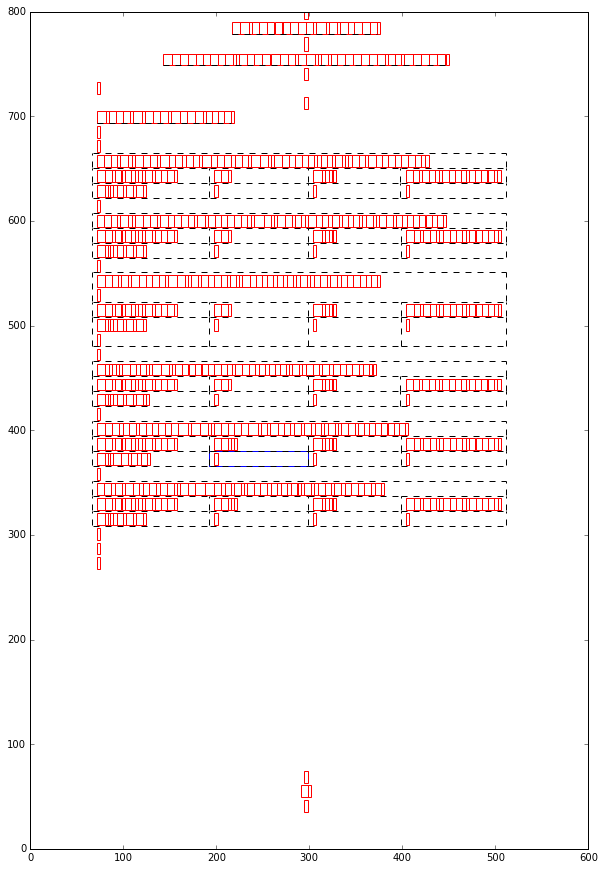

In [71]:
from matplotlib import patches

fig, ax = plt.subplots(figsize = (10,15))

for l in lines:
    x0,y0,x1,y1,_ = l
    plt.plot([x0, x1], [y0, y1], 'k--')
    
draw_rect_bbox(find_bounding_rectangle((250,370), lines), ax, "blue")
    
for c in characters:
    draw_rect(c, ax, "red")

plt.xlim(0,600)
plt.ylim(0,800)
plt.show()

In [126]:
record = {}
no_match = []

for c in characters:
    bbox = find_bounding_rectangle((c.bbox[2], c.bbox[3]), lines)
    
    if bbox is None:
        no_match.append(c)
        continue
        
    if bbox in record.keys():
        record[bbox].append(c)
        continue
        
    record[bbox] = [c]
    
for x in range(100,500,50):
    for y in range(50,800,10):
        bbox = find_bounding_rectangle((x,y), lines)
        
        if bbox is None:
            continue
        
        if bbox in record.keys():
            continue

        record[bbox] = []
        

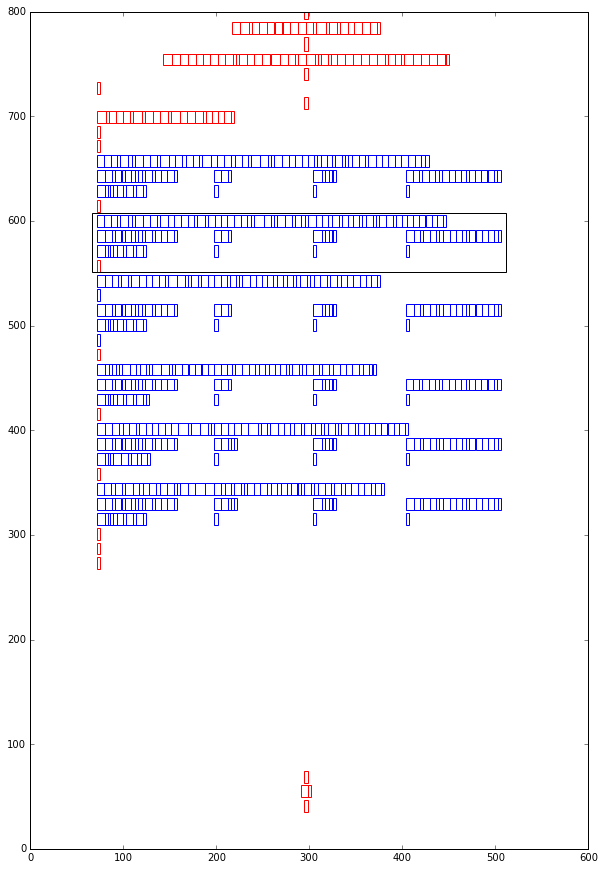

In [127]:
from matplotlib import patches

fig, ax = plt.subplots(figsize = (10,15))

   
for r in record.keys():
    #draw_rect_bbox(r, ax, "g")
    pass
       
for c in characters:
    if c in no_match:
        draw_rect(c, ax, "red")
    else:
        draw_rect(c, ax, "blue")
        
draw_rect_bbox((66.384, 550.87, 511.32, 608.14), ax, "black")

plt.xlim(0,600)
plt.ylim(0,800)
plt.show()

In [128]:
def chars_to_string(chars):
    if not chars:
        return ""
    rows = sorted(list(set(c.bbox[1] for c in chars)), reverse=True)
    text = ""
    for row in rows:
        sorted_row = sorted([c for c in chars if c.bbox[1] == row], key=lambda c: c.bbox[0])
        text += "".join(c.get_text() for c in sorted_row)
    return text

In [129]:
t = random.choice(record.values())
chars_to_string(t)

u'Value (over \xa3140) '

In [130]:
def boxes_to_table(box_record_dict):
    boxes = box_record_dict.keys()
    rows = sorted(list(set(b[1] for b in boxes)), reverse=True)
    table = []
    for row in rows:
        sorted_row = sorted([b for b in boxes if b[1] == row], key=lambda b: b[0])
        table.append([chars_to_string(box_record_dict[b]) for b in sorted_row])
    return table

In [134]:
t = sorted( [(k,v) for k,v in record.items()], key=lambda x: len(x[1]))[3]
t

((66.384, 608.14, 511.32, 665.26),
 [<LTChar 292.008,651.700,298.680,662.956 matrix=[1.00,0.00,0.00,1.00, (292.01,654.22)] font='ABCDEE+Arial,Bold' adv=6.672 text=u'c'>])

In [135]:
r = sorted( [(k,v) for k,v in record.items()], key=lambda x: x[0][1], reverse=True)[0]
print r[0]
print r[1][0]

(66.384, 650.98, 511.32, 665.26)
<LTChar 72.024,651.700,79.356,662.956 matrix=[1.00,0.00,0.00,1.00, (72.02,654.22)] font='ABCDEE+Arial,Bold' adv=7.332 text=u'T'>


In [131]:
boxes_to_table(record)

[[u'The Rt Hon George Osborne MP, Chanellor of the Exchequer '],
 [u'Date gift given ', u'To ', u'Gift ', u'Value (over \xa3140) '],
 [u'Nil return ', u' ', u' ', u' '],
 [u'c'],
 [u'The Rt Hon Danny Alexander MP, ChiefSecretary to the Treasury '],
 [u'Date gift given ', u'To ', u'Gift ', u'Value (over \xa3140) '],
 [u'Nil return ', u' ', u' ', u' '],
 [u' '],
 [u'David Gauke MP, Financial Secretary to the Treasury  '],
 [u'Date gift given ', u'To ', u'Gift ', u'Value (over \xa3140) '],
 [u'Nil return  ', u' ', u' ', u' '],
 [u'Priti Patel MP, Exchequer Secretary to the Treasury  '],
 [u'Date gift given ', u'To ', u'Gift ', u'Value (over \xa3140) '],
 [u'Nil return  ', u' ', u' ', u' '],
 [u'Andrea Leadsom MP, Economic Secretary to the Treasury '],
 [u'Date gift given ', u'To   ', u'Gift ', u'Value (over \xa3140) '],
 [u'Nil Return ', u' ', u' ', u' '],
 [u'Lord Deighton, Commercial Secretary to the Treasury '],
 [u'Date gift given ', u'To   ', u'Gift ', u'Value (over \xa3140) '],
 [u'

In [125]:
x,y = (298.716,652.700)

v_intersects = [l for l in lines
                if l[4] == "V"
                and does_it_intersect(y, (l[1], l[3]))]

h_intersects = [l for l in lines
                if l[4] == "H"
                and does_it_intersect(x, (l[0], l[2]))]

if len(v_intersects) < 2 or len(h_intersects) < 2:
    raise Exception(1)

v_left = [v[0] for v in v_intersects
          if v[0] < x]

v_right = [v[0] for v in v_intersects
          if v[0] > x]

if len(v_left) == 0 or len(v_right) == 0:
    raise Exception(1)

x0,x1 = max(v_left), min(v_right)

h_down = [h[1] for h in h_intersects
          if h[1] < y]

h_up = [h[1] for h in h_intersects
          if h[1] > y]

if len(h_down) == 0 or len(h_up) == 0:
    raise Exception(1)

y0,y1 = max(h_down), min(h_up)

print (x0,y0,x1,y1)  
# (66.384, 650.98, 511.32, 665.26)


(66.384, 608.14, 511.32, 665.26)
